#### Importing the libraries :-

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob
import os

import tensorflow as tf
import keras
from keras.models import Model
from keras.layers import Dense,Dropout,Flatten

from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Conv2D,MaxPooling2D,Activation,AveragePooling2D,BatchNormalization
from keras.models import Sequential

import warnings
warnings.filterwarnings("ignore")
print("Module and Packages imported successfully.....!")

Module and Packages imported successfully.....!


#### Loading reading :-

In [2]:
train_dir = "E:/Study/Final year/Dataset/Training/"
val_dir = "E:/Study/Final year/Dataset/Validation/"

#### Data reading :-

In [3]:
def get_files(directory):
  if not os.path.exists(directory):
    return 0
  count=0
  for current_path,dirs,files in os.walk(directory):
    for dr in dirs:
      count+= len(glob.glob(os.path.join(current_path,dr+"/*")))
  return count    

In [4]:
train_samples =get_files(train_dir)
num_classes=len(glob.glob(train_dir+"/*"))
val_samples=get_files(val_dir) 
print("Classes are :- ", num_classes)
print("Total train images :-", train_samples)
print("Total validation images :-", val_samples)

Classes are :-  2
Total train images :- 8000
Total validation images :- 2000


#### Data preprocessing :-

In [5]:
train_datagen=ImageDataGenerator(rescale=1./255,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   validation_split=0.2, 
                                   horizontal_flip=True)

validation_datagen=ImageDataGenerator(rescale=1./255,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   validation_split=0.2, 
                                   horizontal_flip=True)

In [6]:
img_width,img_height =299,299
input_shape=(img_width,img_height,3)
batch_size =32

train_generator =train_datagen.flow_from_directory(train_dir,
                                                   target_size=(img_width,img_height),
                                                   batch_size=batch_size)
validation_generator = validation_datagen.flow_from_directory(
                                                    val_dir, 
                                                    target_size=(img_height, img_width),
                                                    batch_size=batch_size) 

Found 8000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


In [7]:
train_generator.class_indices

{'Adenocarcinoma': 0, 'Squanomous Cell Carcinoma': 1}

#### CNN 3 Layer Parameter Building

In [8]:
model = Sequential()
model.add(Conv2D(32, (5, 5), input_shape=input_shape, activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(3, 3)))

model.add(Conv2D(64, (3, 3),activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, (3, 3),activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(256,activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))
model.add(Dense(128,activation='relu'))  
model.add(BatchNormalization())
model.add(Dense(num_classes,activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 295, 295, 32)      2432      
_________________________________________________________________
batch_normalization (BatchNo (None, 295, 295, 32)      128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 98, 98, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 96, 96, 64)        18496     
_________________________________________________________________
batch_normalization_1 (Batch (None, 96, 96, 64)        256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 48, 48, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 46, 46, 128)       7

In [9]:
opt=tf.keras.optimizers.Adam(lr=0.01)
model.compile(optimizer=opt,loss='categorical_crossentropy',metrics=['accuracy','Recall','Precision','AUC'])
train=model.fit(train_generator,
                          epochs=15,
                          steps_per_epoch=train_generator.samples // batch_size,
                          validation_data=validation_generator,
                          validation_steps= validation_generator.samples // batch_size,
                          verbose=1)

Epoch 1/15
250/250 [==============================] - 657s 3s/step - loss: 0.3294 - accuracy: 0.8730 - recall: 0.8730 - precision: 0.8730 - auc: 0.9382 - val_loss: 1.8021 - val_accuracy: 0.5983 - val_recall: 0.5983 - val_precision: 0.5983 - val_auc: 0.6336
Epoch 2/15
250/250 [==============================] - 626s 3s/step - loss: 0.2685 - accuracy: 0.8898 - recall: 0.8898 - precision: 0.8898 - auc: 0.9563 - val_loss: 0.3422 - val_accuracy: 0.8599 - val_recall: 0.8599 - val_precision: 0.8599 - val_auc: 0.9400
Epoch 3/15
250/250 [==============================] - 625s 2s/step - loss: 0.2282 - accuracy: 0.9056 - recall: 0.9056 - precision: 0.9056 - auc: 0.9683 - val_loss: 0.5529 - val_accuracy: 0.8014 - val_recall: 0.8014 - val_precision: 0.8014 - val_auc: 0.8989
Epoch 4/15
250/250 [==============================] - 621s 2s/step - loss: 0.1943 - accuracy: 0.9216 - recall: 0.9216 - precision: 0.9216 - auc: 0.9769 - val_loss: 0.5310 - val_accuracy: 0.8311 - val_recall: 0.8311 - val_precisio

Model Saving :-

In [10]:
from tensorflow.keras.models import load_model
model.save('lungcancerdetection_CNN.h5')

In [15]:
from skimage import transform
from PIL import Image
def predict_image(file):
    np_image = Image.open(file)
    np_image = np.array(np_image).astype('float32')/255
    np_image = transform.resize(np_image, (299, 299, 3))
    image = np.expand_dims(np_image, axis = 0)
    pred= model.predict(image)
    k = np.argmax(pred,axis=1)
    clas=labels[k[0]]
    plt.imshow(plt.imread(file))
    plt.title("predicted:" +str(clas))
    plt.show()

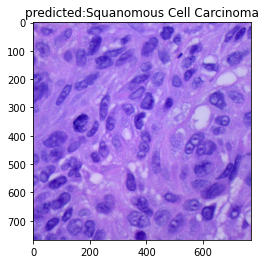

In [24]:
predict_image("E:/Study/Final year/Dataset/Validation/Squanomous Cell Carcinoma/lungscc4001.jpeg")

#### Accuracy graph :-

In [17]:
train.history

{'loss': [0.3293796479701996,
  0.2685050666332245,
  0.22822296619415283,
  0.1942688524723053,
  0.1962895691394806,
  0.1695254147052765,
  0.19077487289905548,
  0.14227712154388428,
  0.15130062401294708,
  0.13194037973880768,
  0.11518493294715881,
  0.11029545962810516,
  0.11714562773704529,
  0.10330739617347717,
  0.10158322751522064],
 'accuracy': [0.8730000257492065,
  0.8897500038146973,
  0.9056249856948853,
  0.921625018119812,
  0.9206249713897705,
  0.9330000281333923,
  0.9238749742507935,
  0.9446250200271606,
  0.9465000033378601,
  0.9490000009536743,
  0.9568750262260437,
  0.9585000276565552,
  0.9558749794960022,
  0.9620000123977661,
  0.9612500071525574],
 'recall': [0.8730000257492065,
  0.8897500038146973,
  0.9056249856948853,
  0.921625018119812,
  0.9206249713897705,
  0.9330000281333923,
  0.9238749742507935,
  0.9446250200271606,
  0.9465000033378601,
  0.9490000009536743,
  0.9568750262260437,
  0.9585000276565552,
  0.9558749794960022,
  0.9620000123

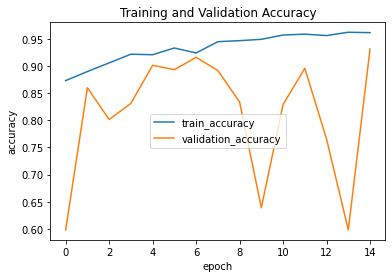

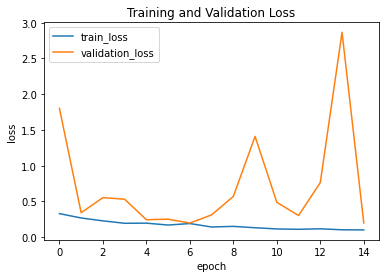

In [18]:
def plot_accuracy(train,title):
    plt.title(title)
    plt.plot(train.history['accuracy']) 
    plt.plot(train.history['val_accuracy']) 
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train_accuracy', 'validation_accuracy'], loc='best')
    plt.show()
    
def plot_loss(train,title):
    plt.title(title)
    plt.plot(train.history['loss'])
    plt.plot(train.history['val_loss'])
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train_loss', 'validation_loss'], loc='best')
    plt.show()

    
plot_accuracy(train,'Training and Validation Accuracy')
plot_loss(train,'Training and Validation Loss')

#### Confusion Matrix :-

##### Training :-

In [19]:
train_generator.reset()
predictions = model.predict_generator(generator = train_generator)
y_pred = [np.argmax(probas) for probas in predictions]
y_test = train_generator.classes

In [20]:
labels_map = (train_generator.class_indices)
labels = dict((v,k) for k,v in labels_map.items())
predict = [labels[k] for k in y_pred]

filenames = train_generator.filenames
results = pd.DataFrame({"Filename":filenames,"Predictions":predict})

In [21]:
from sklearn.metrics import confusion_matrix
def plot_confusion_matrix(test_y,predict_y):
    c = confusion_matrix(test_y, predict_y)
    cmap = sns.light_palette("black")
    plt.figure(figsize=(10,4))
    sns.heatmap(c, annot = True, cmap=cmap, fmt=".1f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()

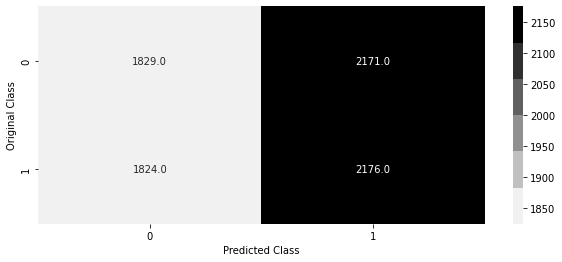

In [22]:
import seaborn as sns
plot_confusion_matrix(y_test, y_pred) 

##### Validation :-

In [20]:
validation_generator.reset()
predictions = model.predict_generator(generator = validation_generator)
y_pred = [np.argmax(probas) for probas in predictions]
y_test = validation_generator.classes

In [21]:
labels_map = (train_generator.class_indices)
labels = dict((v,k) for k,v in labels_map.items())
predict = [labels[k] for k in y_pred]

filenames = validation_generator.filenames
results = pd.DataFrame({"Filename":filenames,"Predictions":predict})

In [22]:
from sklearn.metrics import confusion_matrix
def plot_confusion_matrix(test_y,predict_y):
    c = confusion_matrix(test_y, predict_y)
    cmap = sns.light_palette("black")
    plt.figure(figsize=(10,4))
    sns.heatmap(c, annot = True, cmap=cmap, fmt=".1f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()

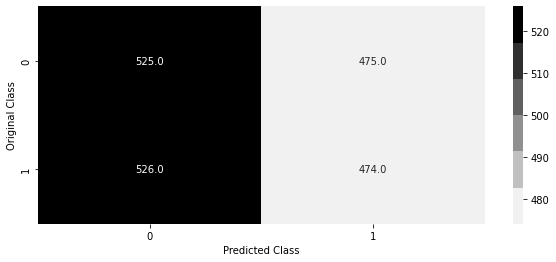

In [23]:
import seaborn as sns
plot_confusion_matrix(y_test, y_pred) 